# LAB 4. NON-PARAMETRIC METHODS

This notebook, by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es) and [oscar.barquero@urjc.es](mailto:oscar.barquero@urjc.es)

UPDATE: 22nd Nov 2023

In this notebook we will analyze and compare different non-parametric methods over the `pima_indian_diabetes` dataset. Specifically, we will learn:

- How to train $K-$NN, DTs, Random Forest, Gradient Boosting and MLP algorithms.
- How to set their hyperparameters (model selection)
- How to evaluate and compare their performance (model evaluation)


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

# 0. Load the data 

In [3]:
path = './data/'
filename = 'pima_indian_diabetes.csv'
df = pd.read_csv(filename)

# take a look to the data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, auc

def get_metrics(confmat):
    '''Unravel confusion matrix and calculate performance metrics'''
    tn, fp, fn, tp = confmat.ravel()
    
    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv)/(sen+ppv)
    
    return acc, sen, esp, ppv, fsc
    
def print_performance_metrics(confmat_train, *confmat_test):
    '''Print performance metrics'''
    
    if not confmat_test:
        acc, sen, esp, ppv, fsc = get_metrics(confmat_train)
        print('ACC: %2.2f' %(100*acc))
        print('SEN: %2.2f' %(100*sen))
        print('ESP: %2.2f' %(100*esp))
        print('PPV: %2.2f' %(100*ppv))
        print('F1: %2.2f' %(100*fsc))
    else:
        acc_train, sen_train, esp_train, ppv_train, fsc_train = get_metrics(confmat_train)
        acc_test, sen_test, esp_test, ppv_test, fsc_test = get_metrics(confmat_test[0])
        
        print('PERFORMANCE METRICS')
        print('\tTRAIN\tTEST')
        print('ACC:\t%2.2f\t%2.2f' %(100*acc_train, 100*acc_test))
        print('SEN:\t%2.2f\t%2.2f' %(100*sen_train, 100*sen_test))
        print('ESP:\t%2.2f\t%2.2f' %(100*esp_train, 100*esp_test))
        print('PPV:\t%2.2f\t%2.2f' %(100*ppv_train, 100*ppv_test))
        print('F1:\t%2.2f\t%2.2f'  %(100*fsc_train, 100*fsc_test))
        
def plot_roc_curve(y,y_prob):
    
    '''Plot ROC-AUC Curve and target probability'''
    
    ejex, ejey, _ = roc_curve(y, y_prob)
    roc_auc = auc(ejex, ejey)

    plt.figure(figsize = (12,4))
    
    # ROC-AUC CURVE
    plt.subplot(1,2,1)
    plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Perfect classifier')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR (1-ESP)')
    plt.ylabel('SEN')
    plt.legend(loc="lower right")
    
    # PROB DENSITY 
    idx_0 = (y==0)
    idx_1 = (y==1)
    
    plt.subplot(1,2,2)
    plt.hist(y_prob[idx_0],density=1,bins = 20, label='y=0',alpha=0.5)
    plt.hist(y_prob[idx_1],density=1,bins = 20, facecolor='red',label='y=1',alpha=0.5)
    plt.legend()
    plt.xlabel('target probability')
    
    plt.show()

def plot_confusion_matrix(confmat_train, *confmat_test):
    ''' Plot confusion matrix
        - A single confusion matrix
        - Comparing two confusion matrices, if provided
    '''
    
    if not confmat_test:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_train.shape[0]):
            for j in range(confmat_train.shape[1]):
                ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

        plt.xlabel('predicted label')
        plt.ylabel('true label')

        plt.tight_layout()
        plt.show()
        
    else:
        fig, ax = plt.subplots(1,2,figsize=(6, 6))
        ax[0].matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_train.shape[0]):
            for j in range(confmat_train.shape[1]):
                ax[0].text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

        ax[1].matshow(confmat_test[0], cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_test[0].shape[0]):
            for j in range(confmat_test[0].shape[1]):
                ax[1].text(x=j, y=i, s=confmat_test[0][i, j], va='center', ha='center')
    
        ax[0].set_xlabel('predicted label')
        ax[0].set_ylabel('true label')
        ax[0].set_title('TRAIN')
        
        ax[1].set_xlabel('predicted label')
        ax[1].set_ylabel('true label')
        ax[1].set_title('TEST')

        plt.tight_layout()
        plt.show()

def analyze_train_test_performance(clf, X_train, X_test, y_train, y_test):
    
    '''Analyze Train and Test Performance'''
    
    # get predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)
    
    # get confusion matrices
    confmat_train = confusion_matrix(y_train, y_pred_train)
    confmat_test  = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrices and provide metrics
    print_performance_metrics(confmat_train, confmat_test)
    plot_confusion_matrix(confmat_train, confmat_test)

    # Plot ROC curve
    y_prob = clf.predict_proba(X_test)[:,1]
    plot_roc_curve(y_test,y_prob)

# 1. Model Selection and evaluation on $K-$NN

We will focus first on the **classification task**, using `Outcome` as target

First, we split our data, but we do it wisely in order build a test set as similar as the train set. Since our target variables is *imbalaced* we might want to activate the `stratify` option.

Take a look to the function documentation: [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split)

In [5]:
from sklearn.model_selection import train_test_split

y = df['Outcome']
X = df.drop('Outcome', axis=1)

#STUDENT: FILL IN YOUR CODE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20, stratify=y)
#STUDENT: FILL IN YOUR CODE

print('- Train size:', X_train.shape)
print('- Test size:', X_test.shape)

print('\n- Train target distribution: ', y_train.value_counts().values/len(y_train))
print('- Test target distribution:  ',y_test.value_counts().values/len(y_test))

- Train size: (576, 8)
- Test size: (192, 8)

- Train target distribution:  [0.65104167 0.34895833]
- Test target distribution:   [0.65104167 0.34895833]


<div class = "alert alert-success">
Run the above cell several times, does the target variable distribution change?
</div>

### Standarize/normalize variables

$K-$NN and MLP require the input data to be standarized

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)

## 1.1 Let's set a baseline

Before running our algorithms it is always a good practice to build a baseline model, so you we have a reference of what the results should be.

- In `src.utils` you have implemented some functions to help us calculating and representing different classification metrics. 

- The `analyze_train_test_performance` function provides a comparative summary between training and test metrics.

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	76.91	80.21
SEN:	56.22	55.22
ESP:	88.00	93.60
PPV:	71.52	82.22
F1:	62.95	66.07


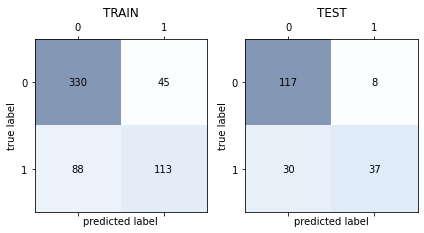

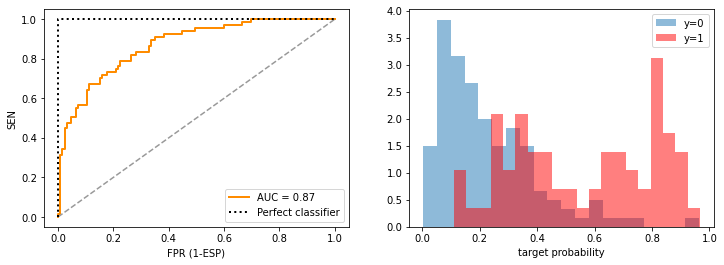

In [7]:
# Logistic regression
lr_model = LogisticRegression().fit(X_train_norm,y_train)

# This a custom function, take a look in src.utils
analyze_train_test_performance(lr_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">
Does this model overfit? Justify your answer
</div>

## 1.2 Model selection: *GridSearch* 

We are going to sweep different values of the parameters of each algorithm, to determine its optimal value. In this sweep, we will use a cross-validation strategy, but never the test set!

To do so, we will be using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) function.

In [8]:
from sklearn.model_selection import GridSearchCV

# These are customized functions: should be in utils.py
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=5):
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer = 'f1', plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])
    std_scores = grid.cv_results_['std_test_score']
        
    params = grid.param_grid[hyper_parameter]
    
    if log:
        params = np.log10(params)
    
    if plot_errors:
        print(params)
        print(scores)
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        plt.plot(params,scores, 'o-')
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()

#### Train an algorithm using `GridSearchCV`

We need to define:

- `scoring`: strategy to evaluate the performance of the cross-validated model on the validation sets. [Metrics in sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

<div class = "alert alert-success">
Take a look to the different metrics in sklearn
</div>

- `param_grid`: dictionary with parameters names (`str`) as keys and lists of parameter settings to try as value. Example:

```python
param_grid = {'n_neighbors': range(1,25)}
```




### $K-$NN

best mean cross-validation score: 0.671
best parameters: {'n_neighbors': 13}
range(1, 25)
[0.66847561 0.60647967 0.65959756 0.62234146 0.66099187 0.63090244
 0.65326423 0.63050813 0.65643089 0.63784146 0.65165854 0.63688618
 0.67093089 0.65005285 0.65371951 0.64629675 0.66511382 0.64758537
 0.66905285 0.66000813 0.6581748  0.65390244 0.66711382 0.6514187 ]


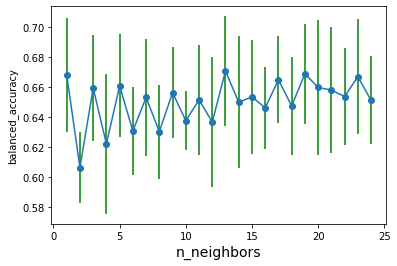

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Metric for the scoring
scorer = 'balanced_accuracy'
# Other possibilities: accuracy (76, 78), balanced_accuracy (76, 80), f1 (100, 76 -> overfitting), roc_auc (76, 78), ....

# param_grid
param_grid = param_grid = {
    'n_neighbors': range(1,25),  # Número de vecinos
    #'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    #'weights': ('uniform', 'distance'),   # Peso de los vecinos (uniforme o ponderado por la inversa de la distancia)
    #'p': [1, 2]  # Parámetro de distancia (1 para distancia Manhattan, 2 para distancia Euclidiana)
}

# Our customized function
grid_knn = hyper_parameters_search(KNeighborsClassifier(), X_train_norm, y_train, param_grid, scorer=scorer)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors',scorer, plot_errors=True)

<div class = "alert alert-success">

Which is the optimal value for $k$? You might want to consider
    
- Different score metrics to guide the CV process<br> 
- Plot the CV errors (`plot_errors = True`) 
</div>

## 1.3 Model evaluation

Once we have selected the model (hyper)-parameters, we evaluate its performance

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	76.22	80.21
SEN:	53.23	59.70
ESP:	88.53	91.20
PPV:	71.33	78.43
F1:	60.97	67.80


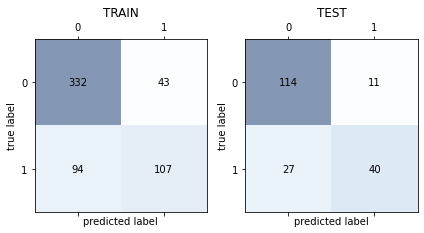

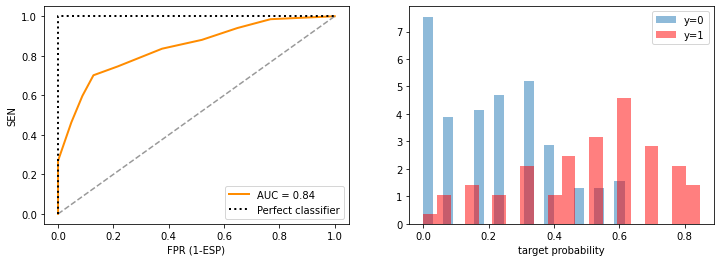

In [9]:
knn_model = grid_knn.best_estimator_
knn_model.fit(X_train_norm, y_train)

analyze_train_test_performance(knn_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">
Does this model overfit? Is it better than our baseline?
</div>

# 2. Decision trees (DTs)

We will repeat the above process for DTs. In this case, the hyper-parameter is `max_depth`.

## 2.1 Model selection

In [10]:
metrics = ['matthews_corrcoef', 'positive_likelihood_ratio', 'balanced_accuracy', 'r2', 'roc_auc_ovo_weighted', 'neg_mean_squared_error', 'normalized_mutual_info_score', 'neg_mean_absolute_percentage_error', 'f1_micro', 'neg_median_absolute_error', 'precision_micro', 'precision_samples', 'explained_variance', 'homogeneity_score', 'precision_macro', 'max_error', 'neg_mean_absolute_error', 'roc_auc_ovr', 'average_precision', 'precision', 'f1_weighted', 'f1_samples', 'roc_auc', 'recall_samples', 'neg_mean_squared_log_error', 'neg_negative_likelihood_ratio', 'adjusted_mutual_info_score', 'jaccard_weighted', 'recall', 'recall_weighted', 'precision_weighted', 'jaccard_samples', 'jaccard', 'roc_auc_ovr_weighted', 'neg_root_mean_squared_error', 'rand_score', 'neg_mean_poisson_deviance', 'recall_micro', 'neg_mean_gamma_deviance', 'mutual_info_score', 'f1_macro', 'fowlkes_mallows_score', 'adjusted_rand_score', 'neg_brier_score', 'neg_log_loss', 'top_k_accuracy', 'f1', 'roc_auc_ovo', 'accuracy', 'jaccard_macro', 'jaccard_micro', 'v_measure_score', 'recall_macro', 'completeness_score']
for m in metrics:
    print(m)

matthews_corrcoef
positive_likelihood_ratio
balanced_accuracy
r2
roc_auc_ovo_weighted
neg_mean_squared_error
normalized_mutual_info_score
neg_mean_absolute_percentage_error
f1_micro
neg_median_absolute_error
precision_micro
precision_samples
explained_variance
homogeneity_score
precision_macro
max_error
neg_mean_absolute_error
roc_auc_ovr
average_precision
precision
f1_weighted
f1_samples
roc_auc
recall_samples
neg_mean_squared_log_error
neg_negative_likelihood_ratio
adjusted_mutual_info_score
jaccard_weighted
recall
recall_weighted
precision_weighted
jaccard_samples
jaccard
roc_auc_ovr_weighted
neg_root_mean_squared_error
rand_score
neg_mean_poisson_deviance
recall_micro
neg_mean_gamma_deviance
mutual_info_score
f1_macro
fowlkes_mallows_score
adjusted_rand_score
neg_brier_score
neg_log_loss
top_k_accuracy
f1
roc_auc_ovo
accuracy
jaccard_macro
jaccard_micro
v_measure_score
recall_macro
completeness_score


best mean cross-validation score: 0.724
best parameters: {'max_depth': 2}


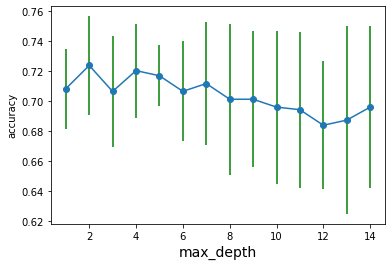

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Decision trees
param_grid = {'max_depth': range(1,15)} #STUDENT LOOK FOR, AT LEAST, ONE OTHER HYPERPARAMETER OF THE DECISION TREE

scorer = 'accuracy'

#HYPER PARAMETER SEARCH
grid_dt = hyper_parameters_search(DecisionTreeClassifier(), X_train_norm, y_train, param_grid, scorer=scorer)

# do the plotting
plot_cv_scoring(grid_dt,'max_depth',scorer, plot_errors=True)

## 2.2 Model evaluation

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	74.48	72.40
SEN:	34.83	34.33
ESP:	95.73	92.80
PPV:	81.40	71.88
F1:	48.78	46.46


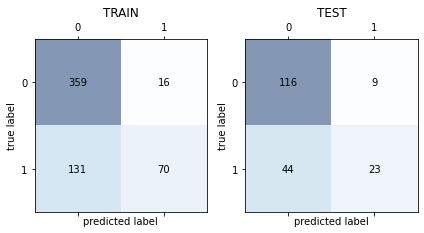

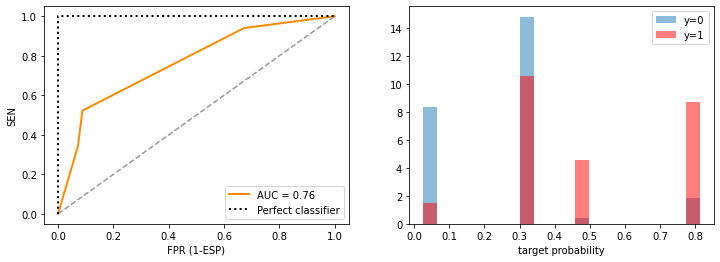

In [12]:
# your code here
dt_model = grid_dt.best_estimator_

analyze_train_test_performance(dt_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What if we change `max_depth`?

</div>

## 2.3 DTs visualization

Trees can be visualized using the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) function

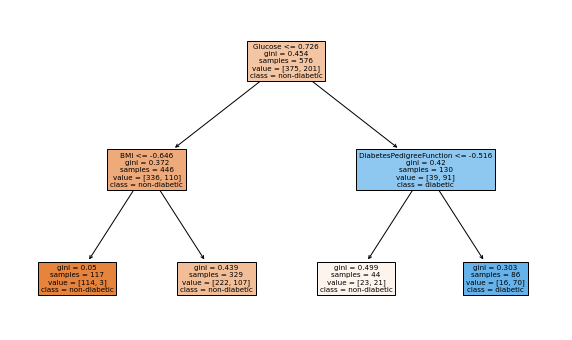

In [13]:
from sklearn.tree import plot_tree

# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=df.columns.drop('Outcome')

plot_tree(
    dt_model,
    feature_names=feature_names, 
    class_names=['non-diabetic','diabetic'], 
    filled=True
)

plt.show()

## 2.4 Feature importance

In [14]:
# feature importance
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

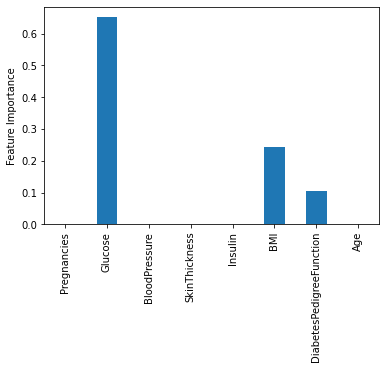

In [15]:
# Plot feature importance
plot_importances(dt_model.feature_importances_, feature_names)

# 3. Random Forest (RF)

We are going to build a Random Forest Model and try to optimize the model by tuning max_depth

best mean cross-validation score: 0.764
best parameters: {'max_depth': 4, 'n_estimators': 500}


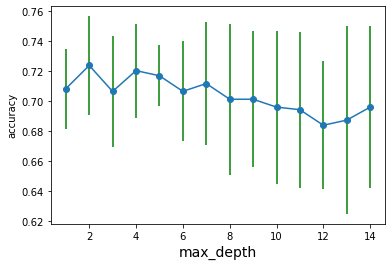

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
param_grid = {'max_depth': range(1,5),
              'n_estimators' : [50,100,200,500,1000]}

# 3.1.Model selection ... this might take a while

# your code here
# ...

#hyper_parameters_search
grid_rf = hyper_parameters_search(RandomForestClassifier(), X_train_norm, y_train, param_grid, scorer=scorer)

# do the plotting
plot_cv_scoring(grid_dt,'max_depth',scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	81.60	78.12
SEN:	59.70	50.75
ESP:	93.33	92.80
PPV:	82.76	79.07
F1:	69.36	61.82


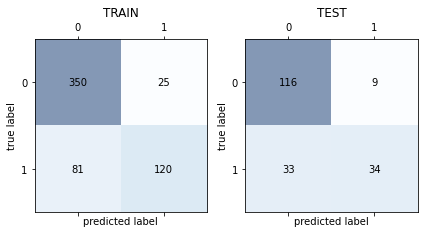

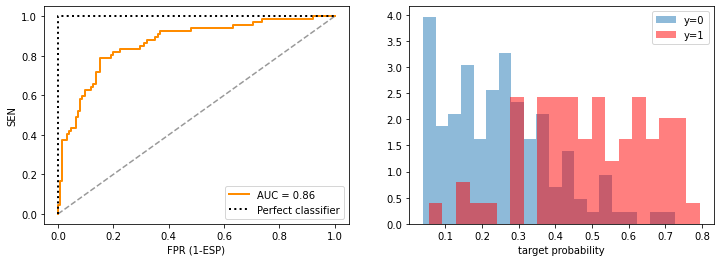

In [17]:
# 3.2 Evaluation

# your code here
# ...
rf_model = RandomForestClassifier(random_state=0, **grid_rf.best_params_).fit(X_train_norm,y_train)
analyze_train_test_performance(rf_model,X_train_norm,X_test_norm,y_train,y_test)

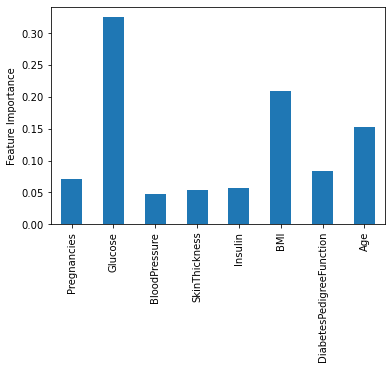

In [18]:
# 3.3 Feature importance

# your code here
# ...
plot_importances(rf_model.feature_importances_, feature_names)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?
- Try another hyperparameter along with max_depth and without tuning n_estimators and once the two hyperparameters are selected increase the number of estimators. Is it better the performance?

</div>

# 4. Gradient Boosting (trees) (BT)

best mean cross-validation score: 0.760
best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


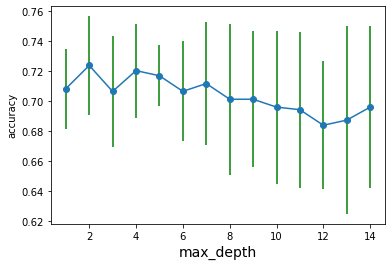

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators' : [50,100,200,500],#, 1000, 2000],
    'learning_rate': [0.1,0.05,0.01, 0.005, 0.001], 
    'max_depth': [1, 2]
} 

# 4.1 Model selection ... this might take a while

# your code here

#hyper parameter search
grid_bt = hyper_parameters_search(GradientBoostingClassifier(), X_train_norm, y_train, param_grid, scorer=scorer)

plot_cv_scoring(grid_dt,'max_depth',scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	84.90	80.21
SEN:	70.15	58.21
ESP:	92.80	92.00
PPV:	83.93	79.59
F1:	76.42	67.24


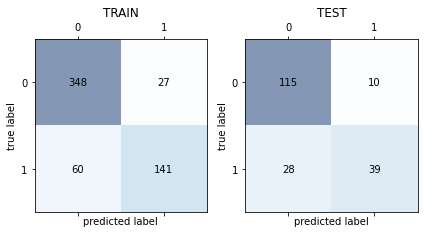

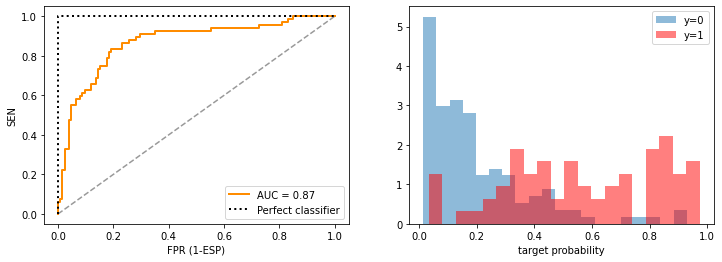

In [20]:
# 4.2 Model evaluation

# your code here
#  ...
bt_model =  GradientBoostingClassifier(random_state=0, **grid_bt.best_params_).fit(X_train_norm,y_train)
analyze_train_test_performance(bt_model,X_train_norm,X_test_norm,y_train,y_test)

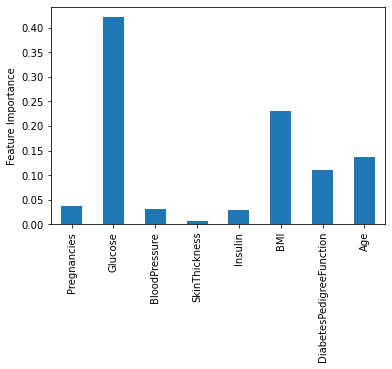

In [21]:
# 4.3 Feature importance

# your code here
# ...
plot_importances(bt_model.feature_importances_, feature_names)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 5. Multilayer Perceptron (MLP)

We are going to build a MLP with 
* 1 hidden layer 5 units
* 1 hidden layer 10 units
* 2 hidden layers 5 units.


best mean cross-validation score: 0.766
best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10,)}


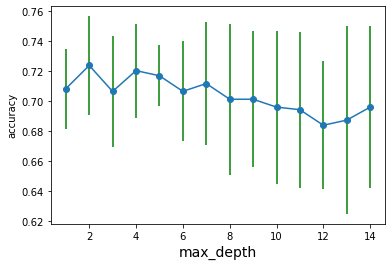

In [22]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier

param_grid = {
    'alpha' : 10.0 ** -np.arange(1, 7), # following recommendation: https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use
    'hidden_layer_sizes': [(5,), (10,), (5, 2)]#STUDENT CODE
}

# 5.1 Model selection ...

# your code here
#  ...

#hyper_parameters_search()
grid_mlp = hyper_parameters_search(MLPClassifier(), X_train_norm, y_train, param_grid, scorer=scorer)

plot_cv_scoring(grid_dt,'max_depth',scorer, plot_errors=True)

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	79.51	76.56
SEN:	66.17	59.70
ESP:	86.67	85.60
PPV:	72.68	68.97
F1:	69.27	64.00


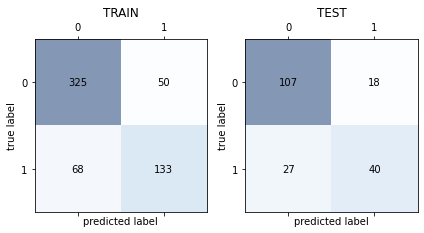

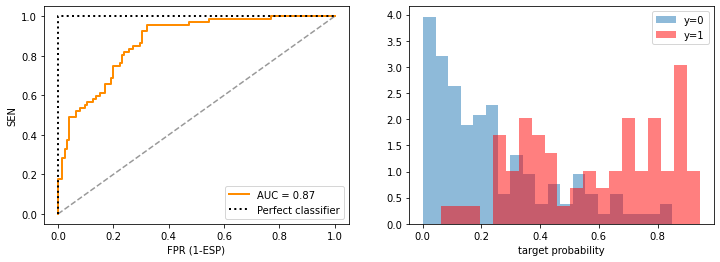

In [23]:
# 5.2 Model evaluation

# your code here
#  ...
mlp_model =  MLPClassifier(random_state=0, **grid_mlp.best_params_).fit(X_train_norm,y_train)
analyze_train_test_performance(mlp_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 6. Model comparison

If you have done all of the above, just run the following cell

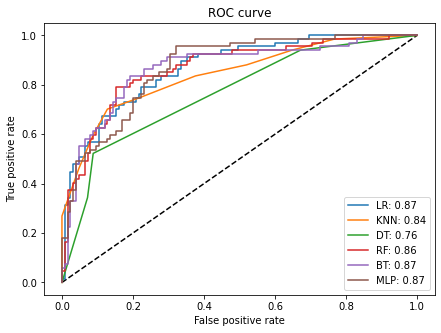

In [24]:
from sklearn.metrics import roc_curve, auc

modelos = {'LR': lr_model, 'KNN':knn_model,'DT':dt_model, 'RF': rf_model, 'BT': bt_model, 'MLP': mlp_model}

plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
for k,v in modelos.items():
    fpr, tpr,_ = roc_curve(y_test, modelos[k].predict_proba(X_test_norm)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = k + ': %0.2f' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

<div class = "alert alert-success">

Taking into account the above results, in your opinion
    
- What is the best model? Justify your answer 
- And the most important feature(s)? 
- If you want to improve these results, what would you do?

</div>

# 7. Your turn!

<div class = "alert alert-success">

1. Apply non-parametric methods to a regression problem. 
    - Which performance metric would you use?


2. Apply non-parametric methods to your dataset. 

</div> 

# Project Ideas

Here there are some tips that you might want to consider for your project:

1. Select a baseline classifier. Which one did you choose? Why?


2. Compare different machine learning methods. Which one provides you with the best performance? Comment on:
    - ... how you selected the best model (hyperparameters you chose and the performance metric you used to do so)
    - ... model overfitting


3. If you used decision trees or decision trees based algorithms, which are the most important features? Are they coherent with you domain expertise?


In all above, justify your decisions.